In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [110]:
#%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi

Found GPU at: /device:GPU:0
Wed Apr 21 11:08:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |   8777MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [170]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True

sess = tf.compat.v1.Session(config=config)

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Audio
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers

%matplotlib inline

In [171]:
BASE_DIR='/content/drive/MyDrive/IIT_Guwahati/IITG_DigitalSignalProcessorsLab/Music_classification_by_Genre/'
IMG_DIR = BASE_DIR+'spectrogram_images/'
IMG_HEIGHT = 216
IMG_WIDTH = 216
NUM_CLASSES = 7
NUM_EPOCHS = 50
BATCH_SIZE = 32
L2_LAMBDA = 0.001

In [172]:
# Randomly select 1 spectrogram from each category for plotting
sample_files = ['230_Hip_hop_music.jpg', 
                 '239_Pop_music.jpg',
                 '243_Vocal.jpg',
                 '233_Rhythm_blues.jpg',
                 '199_Reggae.jpg',
                 '225_Rock_music.jpg',
                 '245_Techno.jpg']

label_dict = {'Hip':0,
              'Pop':1,
              'Vocal':2,
              'Rhythm':3,
              'Reggae':4,
              'Rock':5,
              'Techno':6,
             }

all_files = os.listdir(IMG_DIR)


# Get class weights
label_array = []
for file_ in all_files:
    vals = file_[:-4].split('_')
    label_array.append(label_dict[vals[1]])
    
cl_weight = compute_class_weight(class_weight = 'balanced', 
                                 classes = np.unique(label_array), 
                                 y = label_array)
cl_weight={i:cl_weight[i] for i in range(7)}
# Train-val-test split of files
train_files, test_files, train_labels, test_labels = train_test_split(all_files, 
                                                                      label_array,
                                                                      random_state = 10, 
                                                                      test_size = 0.1
                                                                     )

# Among the test files, keep half for validation
val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels,
                                                                  random_state = 10, 
                                                                  test_size = 0.5
                                                                 )

In [114]:
print('Training files shape')
print(len(train_files))
print()
print('Training labels shape')
print(len(train_labels))
print()

print('Validation files shape')
print(len(val_files))
print()
print('Validation labels shape')
print(len(val_labels))
print()

print('Test files shape')
print(len(test_files))
print()
print('Testing labels shape')
print(len(test_labels))
print()
print('Example of a training file')
print(train_files[0])

Training files shape
1379

Training labels shape
1379

Validation files shape
77

Validation labels shape
77

Test files shape
77

Testing labels shape
77

Example of a training file
1087_Rhythm_blues.jpg


In [115]:
# KEEPING A RECORD OF TEST FILES TO USE THESE FOR OTHER METHODS 

f=open(BASE_DIR+'pred_probas/testset_filenames.txt','w')
test_copy=[i[:-4]+'.wav\n' for i in test_files]
f.writelines(test_copy)

f.close()

f=open(BASE_DIR+'pred_probas/testset_filenames.txt')
x=f.readlines()
x = [t.strip() for t in x]
print('List of test files:')
print(x)

List of test files:
['1565_Techno.wav', '1370_Techno.wav', '244_Techno.wav', '339_Hip_hop_music.wav', '794_Rhythm_blues.wav', '720_Vocal.wav', '342_Pop_music.wav', '304_Rhythm_blues.wav', '1345_Pop_music.wav', '1078_Techno.wav', '997_Rhythm_blues.wav', '1734_Rhythm_blues.wav', '1434_Rock_music.wav', '1442_Pop_music.wav', '655_Techno.wav', '14_Pop_music.wav', '1689_Techno.wav', '406_Reggae.wav', '261_Rhythm_blues.wav', '1378_Pop_music.wav', '1268_Rhythm_blues.wav', '489_Pop_music.wav', '1847_Pop_music.wav', '849_Hip_hop_music.wav', '537_Pop_music.wav', '1474_Vocal.wav', '187_Techno.wav', '419_Vocal.wav', '657_Techno.wav', '592_Pop_music.wav', '551_Hip_hop_music.wav', '1596_Pop_music.wav', '569_Vocal.wav', '1238_Techno.wav', '1178_Techno.wav', '1391_Techno.wav', '1018_Techno.wav', '1004_Rhythm_blues.wav', '1155_Rock_music.wav', '1381_Rock_music.wav', '1574_Rhythm_blues.wav', '411_Pop_music.wav', '1555_Techno.wav', '29_Rhythm_blues.wav', '122_Techno.wav', '1422_Rock_music.wav', '1025_Rhyt

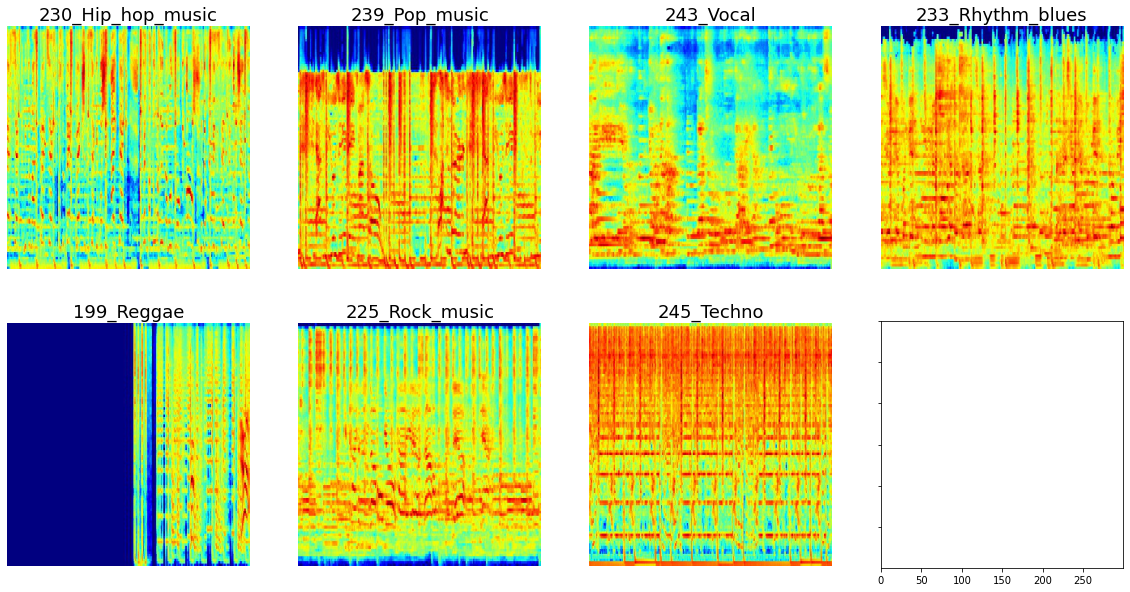

In [116]:
f, axarr = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20,10))
coordinates = [(0,0),(0,1),(0,2),(0,3), 
               (1,0),(1,1),(1,2) ]

for i, file_ in enumerate(sample_files):
    im = Image.open(IMG_DIR + file_)
    axarr[coordinates[i]].imshow(np.asarray(im))
    axarr[coordinates[i]].axis('off')
    axarr[coordinates[i]].set_title(file_[:-4], fontsize=18)


Samples above show that the spectrograms are different for different genres.

In [117]:
#loading the VGG-16 model
conv_base = tf.keras.applications.VGG16(include_top = False, 
                                            weights = 'imagenet', 
                                            input_shape = (IMG_WIDTH, IMG_HEIGHT, 3) # 3 channels - RGB
                                           ) 

In [118]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 216, 216, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 216, 216, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 216, 216, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 108, 108, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 108, 108, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 108, 108, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 54, 54, 128)       0     

In [119]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) # Flatten output and send it to MLP

# 1-layer MLP with Dropout, BN 
model.add(layers.Dense(512, name='dense_1', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
model.add(layers.Dropout(rate=0.3, name='dropout_1')) 
model.add(layers.Activation(activation='relu', name='activation_1'))

model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='dense_output'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_output (Dense)         (None, 7)                 3591      
Total params: 24,155,975
Trainable params: 24,155,975
Non-trainable params: 0
__________________________________________

In [120]:
# Set the convolution base to be not trainable
conv_base.trainable = False
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_output (Dense)         (None, 7)                 3591      
Total params: 24,155,975
Trainable params: 9,441,287
Non-trainable params: 14,714,688
__________________________________

In [121]:
one_hot = OneHotEncoder(handle_unknown='ignore')
label_array=[[0], [1], [2], [3], [4], [5], [6]]
one_hot.fit_transform(label_array).toarray()

def load_batch(file_list):    #to load the batches of file during training with batch_generator
    img_array = []
    idx_array = []
    label_array = []

    for file_ in file_list:
        im = Image.open(IMG_DIR + file_)
        im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
        img_array.append(np.array(im))

        vals = file_[:-4].split('_')
        idx_array.append(vals[0])
        label_array.append([label_dict[vals[1]]])
    
    label_array = one_hot.transform(label_array).toarray()    #transforming to one-hot encoded labels
    img_array = np.array(img_array)/255.0 # Normalize RGB
    
    return img_array, np.array(label_array), np.array(idx_array)

In [122]:
file_list = train_files[0: 10]
batch_img_array, batch_label_array, batch_idx_array = load_batch(file_list)
print('Example of one-hot encoded labels of the first 10 files:')
print()
print(batch_label_array)

Example of one-hot encoded labels of the first 10 files:

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


In [123]:
def batch_generator(files, BATCH_SIZE): #Generates batches of data during training
    L = len(files)

    while True: #needed for keras

        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < L:
            
            limit = min(batch_end, L)
            file_list = files[batch_start: limit]
            batch_img_array, batch_label_array, batch_idx_array = load_batch(file_list)

            yield (batch_img_array, batch_label_array) # a tuple with two numpy arrays with batch_size samples     

            batch_start += BATCH_SIZE   
            batch_end += BATCH_SIZE

In [124]:
# Set optimizer, loss and metrics
optimizer = optimizers.Adam(lr=1e-5)

loss = 'categorical_crossentropy'

metrics = ['categorical_accuracy']

#check point to save the models after each epoch
filepath="/content/drive/MyDrive/IIT_Guwahati/IITG_DigitalSignalProcessorsLab/Music_classification_by_Genre/saved_models/transfer_learning_epoch_{epoch:02d}_{categorical_accuracy:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='categorical_accuracy', 
                                       verbose=0, 
                                       save_best_only=False,
                                       save_freq='epoch'
                                       )
callbacks_list = [checkpoint]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [125]:
STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
VAL_STEPS = len(val_files)//BATCH_SIZE

history = model.fit( batch_generator(train_files, BATCH_SIZE),
                    epochs     = NUM_EPOCHS,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    class_weight = cl_weight, # Check if providing class weight is useful
                    validation_data = batch_generator(val_files, BATCH_SIZE),
                    validation_steps = VAL_STEPS,
                    callbacks = callbacks_list
                  ) 
# consult: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

Epoch 1/50
43/43 [==============================] - 10s 216ms/step - loss: 3.0600 - categorical_accuracy: 0.1558 - val_loss: 2.8672 - val_categorical_accuracy: 0.1406
Epoch 2/50
43/43 [==============================] - 9s 216ms/step - loss: 2.7975 - categorical_accuracy: 0.1897 - val_loss: 2.7652 - val_categorical_accuracy: 0.2031
Epoch 3/50
43/43 [==============================] - 9s 217ms/step - loss: 2.6956 - categorical_accuracy: 0.2111 - val_loss: 2.7045 - val_categorical_accuracy: 0.2344
Epoch 4/50
43/43 [==============================] - 9s 209ms/step - loss: 2.5934 - categorical_accuracy: 0.2522 - val_loss: 2.6364 - val_categorical_accuracy: 0.2344
Epoch 5/50
43/43 [==============================] - 9s 209ms/step - loss: 2.4800 - categorical_accuracy: 0.2910 - val_loss: 2.5808 - val_categorical_accuracy: 0.2500
Epoch 6/50
43/43 [==============================] - 9s 208ms/step - loss: 2.3940 - categorical_accuracy: 0.3396 - val_loss: 2.5376 - val_categorical_accuracy: 0.2812
Epo

In [126]:
history.history

{'categorical_accuracy': [0.16206395626068115,
  0.19079436361789703,
  0.23162584006786346,
  0.27542686462402344,
  0.30215293169021606,
  0.3377876877784729,
  0.36822569370269775,
  0.3570898175239563,
  0.3711952567100525,
  0.4261321425437927,
  0.4142538905143738,
  0.4261321425437927,
  0.451373428106308,
  0.47587230801582336,
  0.4847809970378876,
  0.497401624917984,
  0.49146249890327454,
  0.5144765973091125,
  0.5152190327644348,
  0.5137342214584351,
  0.5300667881965637,
  0.5463994145393372,
  0.5553081035614014,
  0.5634744167327881,
  0.583518922328949,
  0.5857461094856262,
  0.5894580483436584,
  0.6095026135444641,
  0.6043058633804321,
  0.6302895545959473,
  0.62806236743927,
  0.6421678066253662,
  0.6391982436180115,
  0.645137369632721,
  0.6540459990501404,
  0.6763177514076233,
  0.6711210012435913,
  0.6874536275863647,
  0.6956198811531067,
  0.7008166313171387,
  0.7008166313171387,
  0.7297698855400085,
  0.7134372591972351,
  0.7208611965179443,
  0.71

In [127]:
# Save scores on train and validation sets
with open('/content/drive/MyDrive/IIT_Guwahati/IITG_DigitalSignalProcessorsLab/Music_classification_by_Genre/pickle_files/transfer_learning_vgg16_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

#### Determine the best performing model

In [128]:
# Load scores
with open('/content/drive/MyDrive/IIT_Guwahati/IITG_DigitalSignalProcessorsLab/Music_classification_by_Genre/pickle_files/transfer_learning_vgg16_history.pkl', 'rb') as f:
    scores = pickle.load(f)
print(scores.keys())
scores = pd.DataFrame(scores, index=range(1,NUM_EPOCHS+1))

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


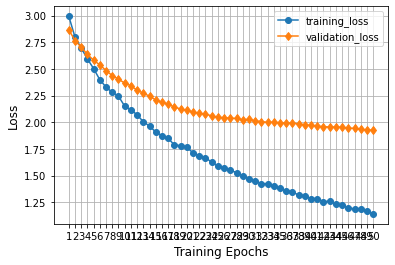

In [129]:
plt.xticks(range(1,NUM_EPOCHS+1))
plt.plot(scores['loss'], marker='o', label='training_loss')
plt.plot(scores['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

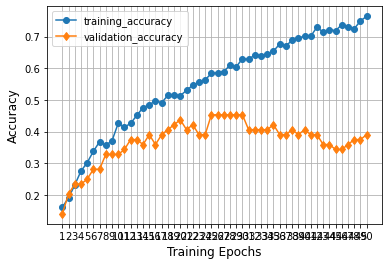

In [130]:
plt.xticks(range(1,NUM_EPOCHS+1))
plt.plot(scores['categorical_accuracy'], marker='o', label='training_accuracy')
plt.plot(scores['val_categorical_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

### Evaluation of the best performing model

Choose the model that does well on the validation set (in terms of minimum loss and maximum accuracy).

In [173]:
model = models.load_model(filepath=BASE_DIR+'saved_models/transfer_learning_epoch_50_0.7639.h5') # this is the best model found

In [174]:
# to plot confusion matrix

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import itertools
from itertools import cycle
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

EVALUATION ON TEST SET:

In [175]:
# Make Prediction on Test set
TEST_STEPS =1
pred_probs = model.predict( batch_generator(test_files, len(test_files)), steps=TEST_STEPS)
pred = np.argmax(pred_probs, axis=-1)

In [176]:
print('Predicted Labels:')
print(list(pred))
print()
print('True Labels')
print(test_labels)

Predicted Labels:
[3, 6, 6, 5, 1, 2, 3, 2, 3, 6, 3, 3, 5, 3, 1, 6, 1, 0, 3, 5, 0, 0, 3, 0, 1, 2, 4, 0, 6, 0, 0, 1, 2, 6, 6, 5, 6, 3, 3, 5, 5, 3, 6, 1, 6, 5, 0, 5, 0, 1, 6, 6, 6, 0, 3, 6, 0, 2, 1, 6, 1, 3, 6, 2, 1, 1, 3, 0, 6, 6, 1, 6, 3, 3, 6, 1, 5]

True Labels
[6, 6, 6, 0, 3, 2, 1, 3, 1, 6, 3, 3, 5, 1, 6, 1, 6, 4, 3, 1, 3, 1, 1, 0, 1, 2, 6, 2, 6, 1, 0, 1, 2, 6, 6, 6, 6, 3, 5, 5, 3, 1, 6, 3, 6, 5, 3, 0, 1, 5, 6, 6, 5, 6, 6, 6, 3, 0, 3, 6, 4, 3, 2, 1, 1, 3, 1, 6, 6, 6, 0, 6, 2, 3, 6, 6, 1]


FOR TEST SET:
Confusion matrix, without normalization
[[ 2  1  1  0  0  2  0]
 [ 3  3  1  6  0  2  1]
 [ 1  0  3  1  0  0  1]
 [ 3  4  1  6  0  1  0]
 [ 1  1  0  0  0  0  0]
 [ 0  1  0  1  0  3  1]
 [ 2  3  0  2  1  1 17]]


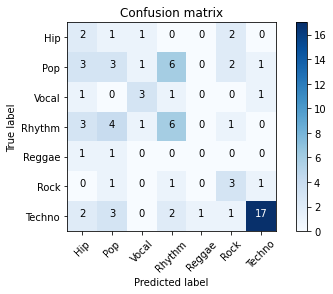

In [177]:
print('FOR TEST SET:')
plot_confusion_matrix(confusion_matrix(y_true=test_labels[:len(pred)], y_pred=pred), 
                      classes=label_dict.keys())

In [178]:
print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true=test_labels[:len(pred)], y_pred=pred)))
x=f1_score(y_true=test_labels[:len(pred)], y_pred=pred, average='weighted')
print(f'Test Set F1-score =  {x}')

Test Set Accuracy =  0.44
Test Set F1-score =  0.45542235166455314


EVALUATION ON TRAIN SET:

In [179]:
# Make Prediction on Train set

TRAIN_STEPS = len(train_files)//BATCH_SIZE
train_pred_probs = model.predict( batch_generator(train_files, BATCH_SIZE), steps=TRAIN_STEPS)
train_pred = np.argmax(train_pred_probs, axis=-1)


In [180]:
print('Predicted Labels:')
print(list(train_pred))
print()
print('True Labels')
print(train_labels)

Predicted Labels:
[3, 3, 6, 0, 1, 1, 6, 1, 4, 5, 3, 3, 5, 1, 2, 3, 4, 1, 1, 0, 5, 1, 6, 6, 6, 0, 1, 6, 2, 5, 6, 6, 6, 1, 1, 1, 2, 3, 1, 5, 0, 1, 3, 3, 1, 3, 3, 5, 0, 3, 3, 3, 0, 4, 2, 6, 5, 3, 6, 3, 2, 4, 6, 3, 0, 0, 1, 1, 3, 6, 1, 6, 6, 6, 0, 6, 3, 1, 1, 5, 5, 1, 5, 3, 4, 6, 3, 3, 1, 6, 0, 3, 1, 1, 3, 3, 2, 2, 6, 0, 6, 6, 6, 3, 6, 1, 0, 6, 1, 6, 6, 5, 3, 6, 3, 3, 0, 3, 6, 3, 1, 1, 0, 3, 5, 0, 1, 3, 1, 6, 3, 5, 2, 6, 0, 6, 1, 1, 0, 1, 1, 3, 6, 6, 6, 4, 1, 0, 6, 0, 1, 5, 0, 5, 1, 3, 3, 3, 6, 3, 2, 0, 1, 6, 6, 3, 6, 1, 0, 5, 6, 2, 6, 3, 6, 3, 3, 0, 3, 1, 3, 6, 6, 0, 1, 5, 3, 6, 1, 3, 5, 6, 0, 6, 6, 6, 0, 0, 2, 6, 6, 3, 5, 6, 3, 3, 6, 1, 1, 6, 5, 1, 3, 4, 0, 6, 1, 0, 3, 1, 0, 2, 5, 3, 3, 5, 1, 2, 1, 6, 6, 3, 6, 6, 3, 1, 1, 5, 6, 5, 1, 3, 6, 6, 1, 5, 3, 1, 4, 2, 3, 0, 6, 4, 5, 6, 6, 4, 2, 3, 0, 3, 0, 5, 0, 5, 6, 6, 3, 2, 1, 1, 6, 6, 3, 3, 6, 6, 6, 5, 3, 5, 1, 1, 0, 5, 5, 3, 0, 1, 1, 6, 5, 6, 3, 2, 1, 1, 0, 1, 1, 3, 6, 3, 6, 6, 3, 6, 6, 1, 3, 3, 6, 0, 1, 2, 6, 4, 2, 0, 5, 2, 5, 6, 6, 6, 6, 

FOR TRAINING SET
Confusion matrix, without normalization
[[ 97   1   0   0   0   0   1]
 [ 25 238   4  30  10  27  25]
 [  0   1  74   0   0   0   1]
 [ 16  11   4 239   7  21  20]
 [  0   0   0   0  26   0   0]
 [  0   2   1   4   0 137   1]
 [ 13  13   1  17   0  12 297]]


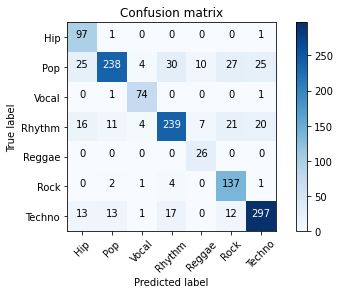

In [181]:
print('FOR TRAINING SET')
plot_confusion_matrix(confusion_matrix(y_true=train_labels[:len(train_pred)], y_pred=train_pred), 
                      classes=label_dict.keys())

In [182]:
print('Train Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true=train_labels[:len(train_pred)], y_pred=train_pred)))
print('Train Set F1-score =  {0:.2f}'.format(f1_score(y_true=train_labels[:len(train_pred)], y_pred=train_pred, average='weighted')))

Train Set Accuracy =  0.81
Train Set F1-score =  0.80


EVALUATION ON VALIDATION SET:

In [183]:
# Make Prediction on Validation set

VAL_STEPS = len(val_files)//BATCH_SIZE
val_pred_probs = model.predict( batch_generator(val_files, BATCH_SIZE), steps=VAL_STEPS)

val_pred = np.argmax(val_pred_probs, axis=-1)

In [184]:
print('Predicted Labels:')
print(list(val_pred))
print()
print('True Labels')
print(val_labels)

Predicted Labels:
[3, 5, 5, 3, 6, 6, 6, 6, 3, 0, 6, 6, 6, 1, 3, 6, 3, 5, 6, 6, 3, 1, 6, 3, 3, 5, 6, 6, 0, 5, 6, 6, 6, 0, 1, 5, 6, 0, 1, 1, 6, 2, 5, 6, 1, 3, 6, 1, 4, 6, 0, 6, 3, 3, 1, 0, 2, 6, 6, 6, 0, 6, 3, 2]

True Labels
[6, 5, 6, 3, 2, 6, 6, 6, 5, 3, 6, 6, 1, 1, 3, 6, 2, 5, 6, 1, 5, 0, 6, 1, 0, 3, 6, 0, 3, 5, 6, 6, 5, 1, 2, 3, 3, 1, 3, 2, 6, 2, 1, 1, 1, 1, 3, 6, 0, 6, 2, 0, 3, 1, 3, 0, 5, 6, 1, 6, 3, 1, 6, 4, 1, 3, 5, 1, 1, 0, 3, 6, 6, 3, 5, 1, 5]


FOR VALIDATION SET
Confusion matrix, without normalization
[[ 1  1  0  1  1  0  2]
 [ 2  2  0  3  0  1  5]
 [ 1  2  1  1  0  0  1]
 [ 3  2  0  3  0  2  2]
 [ 0  0  1  0  0  0  0]
 [ 0  0  1  2  0  3  1]
 [ 0  1  0  2  0  1 15]]


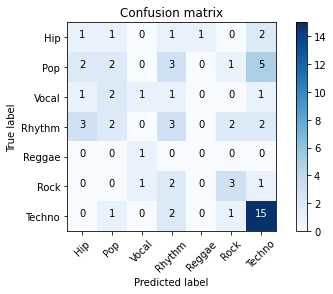

In [185]:
print('FOR VALIDATION SET')
plot_confusion_matrix(confusion_matrix(y_true=val_labels[:len(val_pred)], y_pred=val_pred), 
                      classes=label_dict.keys())

In [186]:
print('Validationi Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true=val_labels[:len(val_pred)], y_pred=val_pred)))
print('Validation Set F1-score =  {0:.2f}'.format(f1_score(y_true=train_labels[:len(val_pred)], y_pred=val_pred, average='weighted')))

Validationi Set Accuracy =  0.39
Validation Set F1-score =  0.22
